# Machine Learning Project

Learning from Titanic Dataset: Can we accurately predict if a person, given a set of attributes, would have survived if they were on the titanic? Which variables have the greatest impact on survival and what model gives the best performance? 

Link to data: https://www.kaggle.com/c/titanic/data

In [2]:
# Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pandas_profiling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix

import xgboost as xgb

import keras
from keras.layers import Dense, Activation, Dropout
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD



Using TensorFlow backend.


In [3]:
#importing file
path = '/Users/jackphillips/Downloads/'
filename = 'train_titanic.csv'

train = pd.read_csv(path+filename)

In [4]:
#importing file
path = '/Users/jackphillips/Downloads/'
filename = 'test_titanic.csv'

test = pd.read_csv(path+filename)

In [5]:
#importing file
path = '/Users/jackphillips/Downloads/'
filename = 'gender_submission.csv'

test_y = pd.read_csv(path+filename)

In [6]:
#taking a look at the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#all column names 
train.columns.tolist()


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [8]:
#checking out the data
train.info()
print('-------------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
F

In [9]:
#gives some basic analysis on the train set
#train.profile_report()

In [10]:
#Ticket,cabin, name can both be removed as they are not helping in predicting 
train = train.drop(['Ticket', 'Cabin','Name'], axis=1)
test = test.drop(['Ticket', 'Cabin','Name'], axis=1)

In [11]:
#Want to see how class effects your survival rate
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index= False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
#Want to see how class effects your survival rate
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index= False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [13]:
#Now lets see how sex effects survival rate
train[['Sex', 'Survived']].groupby(['Sex'], as_index= False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [14]:
#Lets look at SibSp
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index= False).mean().sort_values(by='SibSp', ascending=True)

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
#checking out survival rate for Parch
train[['Parch', 'Survived']].groupby(['Parch'], as_index= False).mean().sort_values(by='Parch', ascending=True)

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


After analyzing the categorical variables, we've definitely seen that the higher classes faired better as well as women by a long shot. Their also seems to be a relationship between SibSp and Parch when it comes to survival rate. However, both of those variables are not normally distributed. 

In [16]:
#Now lets split the data set up by the passengers that survived vs those that didn't
survived=train[train['Survived']==1]
dead=train[train['Survived']==0]

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Survived')

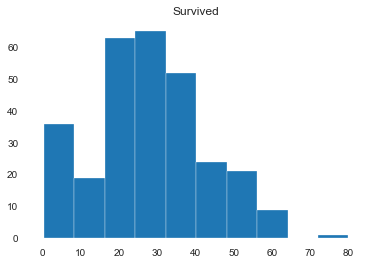

In [17]:
#histogram of ages for passengers that did survive
plt.hist('Age', data=survived)
plt.title('Survived')


Text(0.5, 1.0, 'Did not survive')

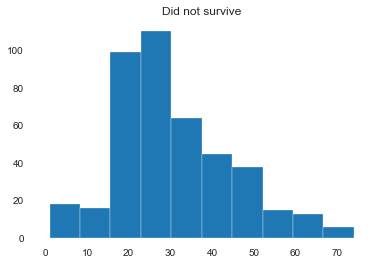

In [18]:
#histogram of ages for passengers that did not survive
plt.hist('Age', data=dead)
plt.title('Did not survive')

In [19]:
#making training and test data
X_train = train.drop(["Survived","PassengerId"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1)
Y_test  = test_y.drop("PassengerId", axis=1)

In [20]:
#checking out missing values
X_train.info()
print('--------------------------------------')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [21]:
#finding mean values to fix data with 
print([X_train["Age"].mean()])
print([X_test["Age"].mean()])
print([X_test["Fare"].mean()])

[29.69911764705882]
[30.272590361445783]
[35.6271884892086]


In [22]:
#fix missing cells and creating dummy variables 

#imputing averages to missing column values 
X_train["Embarked"] = X_train["Embarked"].fillna("S")
X_train["Age"] = X_train["Age"].fillna(29.699)
X_test["Age"] = X_test["Age"].fillna(30.273)
X_test["Fare"] = X_test["Fare"].fillna(35.6272)

#dummies for embarked
edummies_train  = pd.get_dummies(X_train['Embarked'])
edummies_test  = pd.get_dummies(X_test['Embarked'])

X_train = X_train.join(edummies_train)
X_test   = X_test.join(edummies_test)

X_train.drop(['Embarked'], axis=1,inplace=True)
X_test.drop(['Embarked'], axis=1,inplace=True)

#dummies for sex
gdummies_train  = pd.get_dummies(X_train['Sex'])
gdummies_test  = pd.get_dummies(X_test['Sex'])

X_train = X_train.join(gdummies_train)
X_test   = X_test.join(gdummies_test)

X_train.drop(['Sex'], axis=1,inplace=True)
X_test.drop(['Sex'], axis=1,inplace=True)



In [30]:
#joining test and train for cross validation
X=pd.concat([X_train,X_test])
Y=X=pd.concat([Y_train,Y_test])


X_train.to_csv("/Users/jackphillips/Documents/x.csv", index=False)
Y_train.to_csv("/Users/jackphillips/Documents/y.csv", index=False)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


In [37]:
#making sure data is corrected
X_train.info()
print('--------------------------------------')
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass    891 non-null int64
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Fare      891 non-null float64
C         891 non-null uint8
Q         891 non-null uint8
S         891 non-null uint8
female    891 non-null uint8
male      891 non-null uint8
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB
--------------------------------------


AttributeError: 'Series' object has no attribute 'info'

In [36]:
X.head()

,0,Survived
0,0.0,NaN
1,1.0,NaN
2,1.0,NaN
3,1.0,NaN
4,0.0,NaN


In [32]:
#logistic regression model
lreg = LogisticRegression()
lreg.fit(X_train, Y_train)
Y_pred = lreg.predict(X_test)
train_score = lreg.score(X_train, Y_train)
test_score = lreg.score(X_test, Y_test)
print(train_score)
print(test_score)





0.8035914702581369
0.9521531100478469


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
#10 fold cross validation for logistic regression
scores = cross_val_score(lreg, X_train, Y_train, cv=10)
scores.mean()

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

0.795800987402111

In [159]:
#hyper parameter tuning and 10 fold cross validation

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

logreg_cv = GridSearchCV(lreg, param_grid, cv=10)
logreg_cv.fit(X_train, Y_train)

print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

Tuned Logistic Regression Parameter: {'C': 31.622776601683793, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.7957351290684624


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

In [218]:
#testing tuned logreg model on test data
Y_pred=logreg_cv.predict(X_test)
logreg_cv.score(X_test,Y_test)

0.9449760765550239

In [223]:
confusion_matrix(Y_test, Y_pred)



array([[253,  13],
       [ 10, 142]])

In [161]:
#taking a look at the coefficients
lreg.fit(X_train, Y_train).coef_

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[-0.9636122 , -0.03408446, -0.30925865, -0.09289811,  0.00310472,
         0.75214722,  0.63720346,  0.35914702,  2.19111968, -0.44262198]])

In [162]:
#SVM model
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)

train_score = svc.score(X_train, Y_train)
test_score = svc.score(X_test, Y_test)
print(train_score)
print(test_score)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8900112233445566
0.7200956937799043


In [163]:
#10 fold cross validation for SVM
score_svc = cross_val_score(svc, X_train, Y_train, cv=10)
score_svc.mean()



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/

0.7264374077857225

In [164]:
#hyperparameter tuning and cross validation for svm
param_dist = {"C" : [0.001, 0.01, 0.1, 1, 10],
    "gamma" : [0.001, 0.01, 0.1, 1]}

svm_cv = RandomizedSearchCV(svc, param_dist, cv=10)
svm_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(svm_cv.best_params_))
print("Best score is {}".format(svm_cv.best_score_))

Tuned Parameters: {'gamma': 0.01, 'C': 10}
Best score is 0.7710437710437711


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [165]:
#testing tuned svm model on test data
Y_pred=svm_cv.predict(X_test)
svm_cv.score(X_test,Y_test)

0.8397129186602871

In [166]:
#decision tree model
decision = DecisionTreeClassifier()
decision.fit(X_train, Y_train)
Y_pred = decision.predict(X_test)

train_score = decision.score(X_train, Y_train)
test_score = decision.score(X_test, Y_test)
print(train_score)
print(test_score)



0.9820426487093153
0.7751196172248804


In [167]:
#10 fold cross validation for decision tree
score_tree = cross_val_score(decision, X_train, Y_train, cv=10)
score_tree.mean()

0.7823422426512314

In [168]:
#hyperparameter tuning and cross validation for decision tree
param_dist = {
              "max_depth": [3,4,6,8,12,None],
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(decision, param_dist, cv=10)
tree_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Parameters: {'max_depth': 6, 'criterion': 'entropy'}
Best score is 0.8181818181818182


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [169]:
#testing tuned tree model on test data
Y_pred=tree_cv.predict(X_test)
tree_cv.score(X_test,Y_test)

0.8708133971291866

In [170]:
#Random forest model
rf = RandomForestClassifier()
rf_fit=rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

train_score = rf.score(X_train, Y_train)
test_score = rf.score(X_test, Y_test)
print(train_score)
print(test_score)

0.9674523007856342
0.8110047846889952


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [171]:
#10 fold cross validation for RF
score_rf = cross_val_score(rf, X_train, Y_train, cv=10)
score_rf.mean()

0.8048533083645444

In [172]:
#hyperparameter tuning and cross validation for rf
param_dist = {"max_depth": [3,4,6,8,12,None],
               'min_samples_leaf': [1, 2,3, 4],
 'min_samples_split': [2,3, 5, 10],
              "criterion": ["gini", "entropy"],
             'n_estimators': [200, 400, 600, 800, 1000]}

rf_cv = RandomizedSearchCV(rf, param_dist, cv=10)
rf_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 12, 'criterion': 'entropy'}
Best score is 0.8361391694725028


In [173]:
#test score for tuned random forest 
rf_cv.score(X_test,Y_test)

0.8971291866028708

In [174]:
#KNN model
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)

train_score = knn.score(X_train, Y_train)
test_score = knn.score(X_test, Y_test)
print(train_score)
print(test_score)


0.819304152637486
0.7177033492822966


In [175]:
#10 fold cross validation for KNN
score_knn = cross_val_score(knn, X_train, Y_train, cv=10)
score_knn.mean()

0.7083591533310635

In [176]:
#hyperparameter tuning and cross validation for knn
param_dist = {'n_neighbors':[1,2,3,4,5,6,7,8],
             'leaf_size':list(range(1,50))}

knn_cv = RandomizedSearchCV(knn, param_dist, cv=10)
knn_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned Parameters: {'n_neighbors': 7, 'leaf_size': 3}
Best score is 0.7194163860830527


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [177]:
#testing tuned knn model on test data
Y_pred=knn_cv.predict(X_test)
knn_cv.score(X_test,Y_test)

0.6961722488038278

In [178]:
#naive baynes model
gnb = GaussianNB()
gnb.fit(X_train,Y_train)
Y_pred=gnb.predict(X_test)

train_score = gnb.score(X_train, Y_train)
test_score = gnb.score(X_test, Y_test)
print(train_score)
print(test_score)

0.7912457912457912
0.916267942583732


In [179]:
#10 fold cross validation for naive baynes
score_gnb = cross_val_score(gnb, X_train, Y_train, cv=10)
score_gnb.mean()

0.7845891499262285

In [180]:
#hyperparameter tuning and cross validation for gnb
param_dist = {'var_smoothing': [0,.00001,.01,.02,.1]}

gnb_cv = RandomizedSearchCV(gnb, param_dist, cv=10)
gnb_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(gnb_cv.best_params_))
print("Best score is {}".format(gnb_cv.best_score_))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Tuned Parameters: {'var_smoothing': 0}
Best score is 0.7845117845117845


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [181]:
#Tuned gnb model score
gnb_cv.score(X_test,Y_test)

0.916267942583732

In [182]:
#attempting to find parameters
gnb.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [183]:
#ada boost model
ada = AdaBoostClassifier()
ada.fit(X_train,Y_train)
Y_pred=ada.predict(X_test)

train_score = ada.score(X_train, Y_train)
test_score = ada.score(X_test, Y_test)
print(train_score)
print(test_score)

0.8338945005611672
0.9066985645933014


In [184]:
#10 fold cross validation for ada boost
score_ada = cross_val_score(ada, X_train, Y_train, cv=10)
score_ada.mean()

0.8104199296334128

In [185]:
#hyperparameter tuning and cross validation for ada
param_dist = {'n_estimators': [10,50,100,200,300],
             'learning_rate' : [0.01,0.05,0.1,0.3,1]}

ada_cv = RandomizedSearchCV(ada, param_dist, cv=10)
ada_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(ada_cv.best_params_))
print("Best score is {}".format(ada_cv.best_score_))


Tuned Parameters: {'n_estimators': 300, 'learning_rate': 1}
Best score is 0.8148148148148148


In [198]:
#testing tuned ada model on test data
Y_pred=ada_cv.predict(X_test)
ada_cv.score(X_test,Y_test)

0.8923444976076556

In [187]:
#neural net model
nn = MLPClassifier()
nn.fit(X_train,Y_train)
Y_pred=nn.predict(X_test)

train_score = nn.score(X_train, Y_train)
test_score = nn.score(X_test, Y_test)
print(train_score)
print(test_score)

0.8361391694725028
0.930622009569378


In [188]:
#10 fold cross validation for neural net
score_nn = cross_val_score(nn, X_train, Y_train, cv=10)
score_nn.mean()

0.7767986040177051

In [189]:
#hyperparameter tuning and cross validation for nn
param_dist = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

nn_cv = RandomizedSearchCV(nn, param_dist, cv=10)
nn_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(nn_cv.best_params_))
print("Best score is {}".format(nn_cv.best_score_))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed 

Tuned Parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
Best score is 0.77665544332211


In [225]:
#neural net test accuracy for tuned model
Y_pred=nn_cv.predict(X_test)
nn_cv.score(X_test,Y_test)



0.9449760765550239

In [217]:
confusion_matrix(Y_test, Y_pred)

array([[252,  14],
       [  9, 143]])

# Installation guide used to install XG Boost 

https://xgboost.readthedocs.io/en/latest/build.html

In [191]:
#implementing XGBoost model
xg=xgb.XGBClassifier(objective='binary:logistic', n_estimators=10)
xg.fit(X_train,Y_train)
print(xg.score(X_train,Y_train))
print(xg.score(X_test,Y_test))

0.8316498316498316
0.9641148325358851


In [192]:
#Tuning XGBoost model
param_dist = {
    'max_depth': [3,4,5,6,7,8,9],
    'eta':[.001,.005,.01,.1],
    'colsample_bytree':[.1,.5,.8,.85,.87,1],
    'n_estimators':[25,35,42,50]
 
}

xg_cv = RandomizedSearchCV(xg, param_dist, cv=10)
xg_cv.fit(X_train, Y_train)

print("Tuned Parameters: {}".format(xg_cv.best_params_))
print("Best score is {}".format(xg_cv.best_score_))

Tuned Parameters: {'n_estimators': 42, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.8}
Best score is 0.8395061728395061


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [199]:
#tuned XGBoost model performance on test data 
xg_cv.score(X_test,Y_test)

0.8923444976076556

In [194]:
# Creating initial model
model = Sequential()

#Adding model layers
model.add(Dense(20, activation='relu', input_dim=10))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

sgd = SGD(lr = 0.02)

#compiling model
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])


#training model
training=model.fit(X_train, Y_train,epochs = 50, verbose=2,validation_data=(X_test,Y_test))

Train on 891 samples, validate on 418 samples
Epoch 1/50
 - 1s - loss: 1.4080 - accuracy: 0.6352 - val_loss: 0.6397 - val_accuracy: 0.6531
Epoch 2/50
 - 0s - loss: 0.6046 - accuracy: 0.6846 - val_loss: 0.7655 - val_accuracy: 0.6411
Epoch 3/50
 - 0s - loss: 0.5970 - accuracy: 0.6947 - val_loss: 0.7009 - val_accuracy: 0.6531
Epoch 4/50
 - 0s - loss: 0.6075 - accuracy: 0.7138 - val_loss: 0.5976 - val_accuracy: 0.6842
Epoch 5/50
 - 0s - loss: 0.6082 - accuracy: 0.6902 - val_loss: 0.5873 - val_accuracy: 0.6890
Epoch 6/50
 - 0s - loss: 0.5836 - accuracy: 0.7071 - val_loss: 0.5810 - val_accuracy: 0.6699
Epoch 7/50
 - 0s - loss: 0.5799 - accuracy: 0.7003 - val_loss: 0.6695 - val_accuracy: 0.6627
Epoch 8/50
 - 0s - loss: 0.5720 - accuracy: 0.7082 - val_loss: 0.5974 - val_accuracy: 0.6842
Epoch 9/50
 - 0s - loss: 0.5878 - accuracy: 0.6981 - val_loss: 0.5768 - val_accuracy: 0.6842
Epoch 10/50
 - 0s - loss: 0.5666 - accuracy: 0.7138 - val_loss: 0.6150 - val_accuracy: 0.6866
Epoch 11/50
 - 0s - los

In [195]:
# Model after parameter tuning
model = Sequential()

#Adding model layers
model.add(Dense(20, activation='relu', input_dim=10))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

#compiling model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#training model
training=model.fit(X_train, Y_train,epochs = 50, verbose=2)


Epoch 1/50
 - 1s - loss: 0.7362 - accuracy: 0.6611
Epoch 2/50
 - 0s - loss: 0.6278 - accuracy: 0.6712
Epoch 3/50
 - 0s - loss: 0.6016 - accuracy: 0.6914
Epoch 4/50
 - 0s - loss: 0.6098 - accuracy: 0.6857
Epoch 5/50
 - 0s - loss: 0.5930 - accuracy: 0.6925
Epoch 6/50
 - 0s - loss: 0.5784 - accuracy: 0.7082
Epoch 7/50
 - 0s - loss: 0.5622 - accuracy: 0.7194
Epoch 8/50
 - 0s - loss: 0.5422 - accuracy: 0.7329
Epoch 9/50
 - 0s - loss: 0.5324 - accuracy: 0.7508
Epoch 10/50
 - 0s - loss: 0.5163 - accuracy: 0.7565
Epoch 11/50
 - 0s - loss: 0.5041 - accuracy: 0.7609
Epoch 12/50
 - 0s - loss: 0.4923 - accuracy: 0.7778
Epoch 13/50
 - 0s - loss: 0.4788 - accuracy: 0.7733
Epoch 14/50
 - 0s - loss: 0.5009 - accuracy: 0.7789
Epoch 15/50
 - 0s - loss: 0.4784 - accuracy: 0.7924
Epoch 16/50
 - 0s - loss: 0.4682 - accuracy: 0.7890
Epoch 17/50
 - 0s - loss: 0.4825 - accuracy: 0.7890
Epoch 18/50
 - 0s - loss: 0.4630 - accuracy: 0.7856
Epoch 19/50
 - 0s - loss: 0.4789 - accuracy: 0.7834
Epoch 20/50
 - 0s - l

In [201]:
# results for my tuned ANN model
results=model.evaluate(X_test, Y_test)
y_pred = model.predict(X_test)

print(results)


418/418 [==============================] - 0s 32us/step
[0.2754329245484046, 0.9210526347160339]
